### 🔮 Classificação usando KAN (Kolmogorov-Arnold Networks)

#### 🟠 Instalando as bibliotecas necessárias 
Certifique-se de ter instalado o KAN, caso tenha dúvidas veja o tutotial no readme desse projeto

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import torch
from kan import KAN
import matplotlib.pyplot as plt

#### 🟠 Carregando o dataset e fazendo o pré-processamento

In [2]:
df = pd.read_csv('spine_dataset.csv')

In [3]:
X = df.drop(columns=['Class_att', 'Unnamed: 13'])
y = df['Class_att']

In [4]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 'Normal' será 0 e 'Abnormal' será 1

#### 🟠 Dividindo as instâncias entre treino e teste

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 🟠 Normalizando as variáveis

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### 🟠 Transformando os dataframes em tensores

In [7]:
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.long)
test_input = torch.tensor(X_test, dtype=torch.float32)
test_label = torch.tensor(y_test, dtype=torch.long)

In [8]:
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

#### 🟠 Inicializando e treinando a rede KAN

In [9]:
model = KAN(width=[X_train.shape[1], 2], grid=3, k=3)

In [10]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

In [11]:
results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

train loss: 3.65e-01 | test loss: 7.89e-01 | reg: 3.87e+01 : 100%|██| 20/20 [00:11<00:00,  1.68it/s]


#### 📊 Visualizando o modelo e resultados

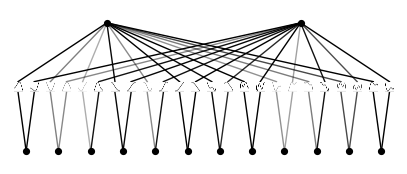

In [13]:
model.plot()

In [14]:
# Obter a acurácia final
final_train_acc = results['train_acc'][-1]
final_test_acc = results['test_acc'][-1]

print(f"Acurácia final no conjunto de treino: {final_train_acc:.4f}")
print(f"Acurácia final no conjunto de teste: {final_test_acc:.4f}")

Acurácia final no conjunto de treino: 0.9476
Acurácia final no conjunto de teste: 0.8387


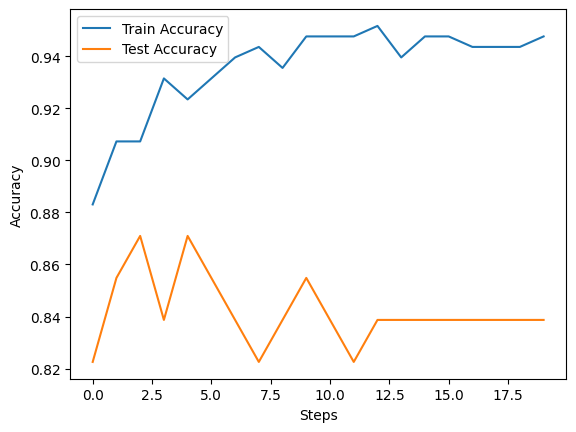

In [15]:
# Plotar os resultados de acurácia (opcional)
plt.plot(results['train_acc'], label='Train Accuracy')
plt.plot(results['test_acc'], label='Test Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

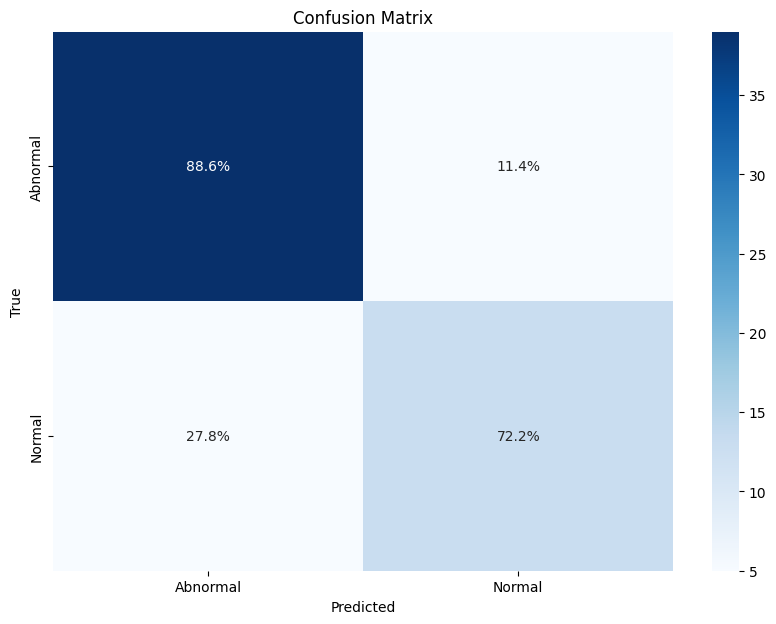

In [28]:
test_outputs = model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()

conf_matrix = confusion_matrix(y_test, test_predictions)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

annot_labels = [['{:.1f}%'.format(value) for value in row] for row in conf_matrix_percent]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=annot_labels, fmt='', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

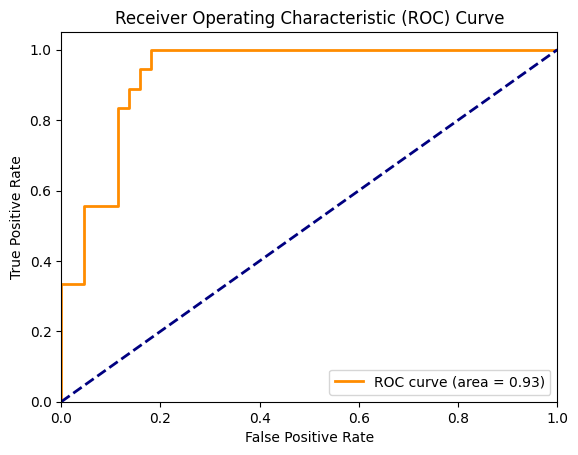

In [29]:
test_probs = torch.softmax(test_outputs, dim=1).detach().numpy()
fpr, tpr, _ = roc_curve(y_test, test_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


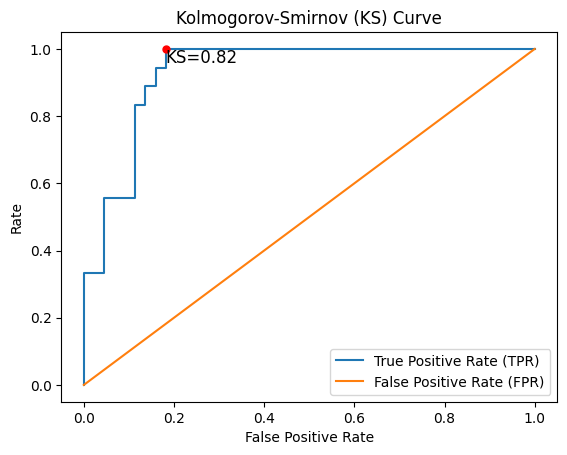

KS Statistic: 0.82


In [30]:
ks_statistic = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)
plt.figure()
plt.plot(fpr, tpr, label='True Positive Rate (TPR)')
plt.plot(fpr, fpr, label='False Positive Rate (FPR)')
plt.plot([fpr[ks_idx]], [tpr[ks_idx]], marker='o', markersize=5, color="red")
plt.text(fpr[ks_idx], tpr[ks_idx], f'KS={ks_statistic:.2f}', fontsize=12, verticalalignment='top')
plt.xlabel('False Positive Rate')
plt.ylabel('Rate')
plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.legend(loc='best')
plt.show()

print(f"KS Statistic: {ks_statistic:.2f}")